In [1]:
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt


In [2]:
def A_AirlightEstimation(HazeImg,kernel_size):
    AirlightEstimation_list=[]
    for ch in range(len(HazeImg.shape)):
        kernel = np.ones((kernel_size,kernel_size), np.uint8)
        eroded = cv2.erode(HazeImg[:, :, ch], kernel)
#         plt.imshow(eroded,cmap='gray')
#         plt.show()
        AirlightEstimation_list.append(int(eroded.max()))
        
    return AirlightEstimation_list
    

In [3]:
def B_BoundCon(HazeImg , AirlightEstimation_list , C1 , C0):


        t_b = np.maximum((AirlightEstimation_list[0] - HazeImg[:, :, 0].astype(float)) / (AirlightEstimation_list[0] - C0),
                         (HazeImg[:, :, 0].astype(float) - AirlightEstimation_list[0]) / (C1 - AirlightEstimation_list[0]))
        t_g = np.maximum((AirlightEstimation_list[1] - HazeImg[:, :, 1].astype(float)) / (AirlightEstimation_list[1] - C0),
                         (HazeImg[:, :, 1].astype(float) - AirlightEstimation_list[1]) / (C1 - AirlightEstimation_list[1]))
        t_r = np.maximum((AirlightEstimation_list[2] - HazeImg[:, :, 2].astype(float)) / (AirlightEstimation_list[2] - C0),
                         (HazeImg[:, :, 2].astype(float) - AirlightEstimation_list[2]) / (C1 - AirlightEstimation_list[2]))

        MaxVal = np.maximum(t_b, t_g, t_r)
        _Transmission = np.minimum(MaxVal, 1)
        
        return _Transmission

In [4]:
def __LoadFilterBank():
    KirschFilters = []
    KirschFilters.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
    KirschFilters.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))
    KirschFilters.append(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]))
    return (KirschFilters)

In [5]:
def __circularConvFilt(Img, Filter):
    FilterHeight, FilterWidth = Filter.shape
    assert (FilterHeight == FilterWidth), 'Filter must be square in shape --> Height must be same as width'
    assert (FilterHeight % 2 == 1), 'Filter dimension must be a odd number.'

    filterHalsSize = int((FilterHeight - 1) / 2)
    rows, cols = Img.shape
    PaddedImg = cv2.copyMakeBorder(Img, filterHalsSize, filterHalsSize, filterHalsSize, filterHalsSize,
                                   borderType=cv2.BORDER_WRAP)
    FilteredImg = cv2.filter2D(PaddedImg, -1, Filter)
    Result = FilteredImg[filterHalsSize:rows + filterHalsSize, filterHalsSize:cols + filterHalsSize]
    return (Result)

In [6]:
def __CalculateWeightingFunction(HazeImg, Filter ,sigma):

    # Computing the weight function... Eq (17) in the paper

    HazeImageDouble = HazeImg.astype(float) / 255.0
    Red = HazeImageDouble[:, :, 2]
    d_r = __circularConvFilt(Red, Filter)

    Green = HazeImageDouble[:, :, 1]
    d_g = __circularConvFilt(Green, Filter)

    Blue = HazeImageDouble[:, :, 0]
    d_b = __circularConvFilt(Blue, Filter)

    return (np.exp(-((d_r ** 2) + (d_g ** 2) + (d_b ** 2)) / (2 * sigma * sigma)))


In [7]:
def C_CalTransmission(HazeImg , _Transmission , regularize_lambda ,sigma):
    rows, cols = _Transmission.shape

    KirschFilters = __LoadFilterBank()

    # Normalize the filters
    for idx, currentFilter in enumerate(KirschFilters):
        KirschFilters[idx] = KirschFilters[idx] / np.linalg.norm(currentFilter)

    # Calculate Weighting function --> [rows, cols. numFilters] --> One Weighting function for every filter
    WFun = []
    for idx, currentFilter in enumerate(KirschFilters):
        WFun.append(__CalculateWeightingFunction(HazeImg, currentFilter  ,sigma))

    # Precompute the constants that are later needed in the optimization step
    tF = np.fft.fft2(_Transmission)
    DS = 0

    for i in range(len(KirschFilters)):
        D = __psf2otf(KirschFilters[i], (rows, cols))
        # D = psf2otf(KirschFilters[i], (rows, cols))
        DS = DS + (abs(D) ** 2)

    # Cyclic loop for refining t and u --> Section III in the paper
    beta = 1  # Start Beta value --> selected from the paper
    beta_max = 2 ** 4  # Selected from the paper --> Section III --> "Scene Transmission Estimation"
    beta_rate = 2 * np.sqrt(2)  # Selected from the paper

    while (beta < beta_max):
        gamma = regularize_lambda / beta

        # Fixing t first and solving for u
        DU = 0
        for i in range(len(KirschFilters)):
            dt = __circularConvFilt(_Transmission, KirschFilters[i])
            u = np.maximum((abs(dt) - (WFun[i] / (len(KirschFilters) * beta))), 0) * np.sign(dt)
            DU = DU + np.fft.fft2(__circularConvFilt(u, cv2.flip(KirschFilters[i], -1)))

        # Fixing u and solving t --> Equation 26 in the paper
        # Note: In equation 26, the Numerator is the "DU" calculated in the above part of the code
        # In the equation 26, the Denominator is the DS which was computed as a constant in the above code

        _Transmission = np.abs(np.fft.ifft2((gamma * tF + DU) / (gamma + DS)))
        beta = beta * beta_rate

    if (showHazeTransmissionMap):
        cv2.imshow("Haze Transmission Map", _Transmission)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        
    return _Transmission

In [8]:
def D_removeHaze(HazeImg, _Transmission ,AirlightEstimation_list, delta,epsilon ):


    # This function will implement equation(3) in the paper

    
    Transmission = pow(np.maximum(abs(_Transmission), epsilon), delta)

    HazeCorrectedImage = copy.deepcopy(HazeImg)
    
    for ch in range(len(HazeImg.shape)):
        temp = ((HazeImg[:, :, ch].astype(float) - AirlightEstimation_list[ch]) / Transmission) + AirlightEstimation_list[ch]
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp

    return (HazeCorrectedImage , Transmission)


In [9]:
def __psf2otf(psf, shape):
#         '''
#             this code is taken from:
#             https://pypi.org/project/pypher/
#         '''

        if np.all(psf == 0):
            return np.zeros_like(psf)

        inshape = psf.shape
        # Pad the PSF to outsize
        psf = __zero_pad(psf, shape, position='corner')

        # Circularly shift OTF so that the 'center' of the PSF is
        # [0,0] element of the array
        for axis, axis_size in enumerate(inshape):
            psf = np.roll(psf, -int(axis_size / 2), axis=axis)

        # Compute the OTF
        otf = np.fft.fft2(psf)

        # Estimate the rough number of operations involved in the FFT
        # and discard the PSF imaginary part if within roundoff error
        # roundoff error  = machine epsilon = sys.float_info.epsilon
        # or np.finfo().eps
        n_ops = np.sum(psf.size * np.log2(psf.shape))
        otf = np.real_if_close(otf, tol=n_ops)

        return otf

In [10]:

def __zero_pad(image, shape, position='corner'):

        shape = np.asarray(shape, dtype=int)
        imshape = np.asarray(image.shape, dtype=int)

        if np.alltrue(imshape == shape):
            return image

        if np.any(shape <= 0):
            raise ValueError("ZERO_PAD: null or negative shape given")

        dshape = shape - imshape
        if np.any(dshape < 0):
            raise ValueError("ZERO_PAD: target size smaller than source one")

        pad_img = np.zeros(shape, dtype=image.dtype)

        idx, idy = np.indices(imshape)

        if position == 'center':
            if np.any(dshape % 2 != 0):
                raise ValueError("ZERO_PAD: source and target shapes "
                                 "have different parity.")
            offx, offy = dshape // 2
        else:
            offx, offy = (0, 0)

        pad_img[idx + offx, idy + offy] = image

        return pad_img




In [11]:
showHazeTransmissionMap = False

def remove_haze(HazeImg , kernel_size ,C1, C0 , regularize_lambda ,delta ,sigma,epsilon):
    AirlightEstimation_list = A_AirlightEstimation(HazeImg,kernel_size)
    _Transmission = B_BoundCon(HazeImg , AirlightEstimation_list , C1 , C0)
    _Transmission = C_CalTransmission(HazeImg , _Transmission , regularize_lambda ,sigma)
    haze_corrected_img,Transmission = D_removeHaze(HazeImg, _Transmission ,AirlightEstimation_list, delta,epsilon)
    HazeTransmissionMap = _Transmission
    return (haze_corrected_img, HazeTransmissionMap)


In [318]:
# import cv2
# import numpy as np

# def nothing(x):
#     pass

# # Load image
# image = cv2.imread('frames/frame_1.png')

# # Create a window
# cv2.namedWindow('image')

# # Create trackbars for color change
# # Hue is from 0-179 for Opencv
# cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# # Set default value for Max HSV trackbars
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize HSV min/max values
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# while(1):
#     # Get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin', 'image')
#     sMin = cv2.getTrackbarPos('SMin', 'image')
#     vMin = cv2.getTrackbarPos('VMin', 'image')
#     hMax = cv2.getTrackbarPos('HMax', 'image')
#     sMax = cv2.getTrackbarPos('SMax', 'image')
#     vMax = cv2.getTrackbarPos('VMax', 'image')

#     # Set minimum and maximum HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Convert to HSV format and color threshold
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     result = cv2.bitwise_and(image, image, mask=mask)

#     # Print if there is a change in HSV value
#     if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display result image
#     cv2.imshow('image', result)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()

In [319]:

# output_dir = 'frames/'


# !ffmpeg -i finall_clip2.mp4 -vf fps=1 frames/frame_%d.png

In [13]:
import cv2
import numpy as np

def sky_segment(file_path):
    # Read the image
    image = cv2.imread(file_path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the sky color in HSV
    lower_sky = np.array([50, 0, 200])  # Adjust these values based your specific sky color
    upper_sky = np.array([170, 255, 255])

    # Create a mask by applying the color range to the HSV image
    mask = cv2.inRange(hsv_image, lower_sky, upper_sky)

    # Apply morphological operations to remove noise from the mask
    kernel =np.ones((3, 3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask[int(2*mask.shape[0]/3):,:]=0
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)
    _, thresholded = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
    sky=cv2.bitwise_and(image, image, mask=thresholded)

    # fig, ax = plt.subplots(1,2,figsize=(20,10))
    # ax[0].imshow(cv2.cvtColor(mask , cv2.COLOR_BGR2RGB))
    _, thresholded = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY_INV)
    image=cv2.bitwise_and(image, image, mask=thresholded)
    # ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.show()
    image[image==0]=255
    return (image , sky)

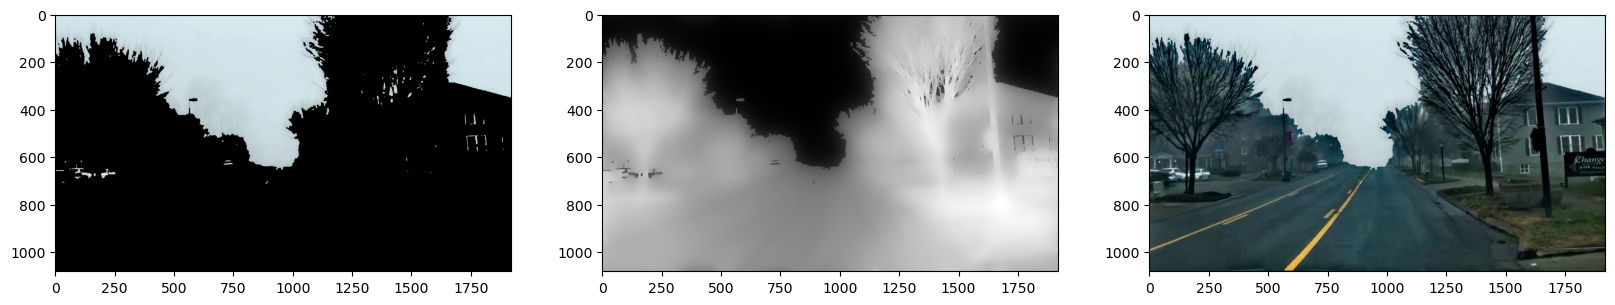

In [15]:
img = cv2.imread('frames/frame_16.png')
HazeImg , sky = sky_segment('frames/frame_16.png')
HazeCorrectedImg, haze_map = remove_haze(HazeImg , kernel_size=15 ,C1=300 , C0=20 , regularize_lambda=0.1 ,delta=0.75 , sigma=0.5,epsilon=0.0001)
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(sky, cv2.COLOR_BGR2RGB))
ax[1].imshow(haze_map, cmap='gray')
ax[2].imshow(cv2.cvtColor(HazeCorrectedImg + sky, cv2.COLOR_BGR2RGB))
plt.show()


In [17]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
# Define the input and output folder paths
in_folder_path = "frames"
out_folder_path = "defog_v2"
i=0


def last_4chars(x):
    return(int(x[6:-4]))

for file_name in tqdm(sorted(os.listdir(in_folder_path), key = last_4chars)):

    i+=1
    if file_name.endswith(f"{i}.png"):
        # Construct the full file path
        file_path = os.path.join(in_folder_path, file_name)
        HazeImg , sky = sky_segment(file_path)
        # Read the image using OpenCV
#         HazeImg = cv2.imread(file_path)
        HazeCorrectedImg, haze_map = remove_haze(HazeImg , kernel_size=15 ,C1=300 , C0=20 , regularize_lambda=0.1 ,delta=0.75 , sigma=0.5,epsilon=0.0001)
        
        output_path = os.path.join(out_folder_path, file_name)

        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
        ax.imshow(cv2.cvtColor(HazeCorrectedImg+sky, cv2.COLOR_BGR2RGB))
        output_path = os.path.join(out_folder_path, file_name)
        ax.axis('off')
        plt.savefig(output_path)
        plt.close()
        
        
#         fig, ax = plt.subplots(1, 2, figsize=(40, 20))
#         ax[0].imshow(cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB))
#         ax[1].imshow(haze_map, cmap='gray')
# #         ax[1].imshow(cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB))
#         output_path = os.path.join(out_folder_path,'mask'+ file_name)
#         ax[0].axis('off')
#         ax[1].axis('off')
#         plt.savefig(output_path)
#         plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [11:50<00:00,  9.34s/it]


In [20]:
# Path to the directory containing the frames
frames_folder = "defog_v2"

# Path to the output video file
output_video = "video_defoged.mp4"

# Get the list of frame files in the frames folder
frame_files = sorted(os.listdir(in_folder_path), key = last_4chars)

# Read the first frame to get the size
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
frame_height, frame_width, _ = first_frame.shape

# Create a VideoWriter object to write the frames to a video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Specify the codec (MP4V)
fps = 3  # Specify the frames per second
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_folder, frame_file)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# Release the video writer
video_writer.release()